## CancelOut    
**time  : 2019/12/23**  
**author: mjl**  
**paper : CancelOut: A Layer for Feature Selection in Deep Neural Networks**    

这是一个关于特征选择的模型， CancelOut是一个特征选择层， 其能够对数据进行按权重进行选择。  
CancelOut背后的思想是在模型训练过程中更新它的权重，以至于不相关的特征被取消通过使其权重为负数。 因此， 那些对于模型训练学习贡献大的使其权重为正值。  
一： 如果在CancelOut层中经过 $\delta()$激活函数后， 其结果为0 ， 那么其对于网络的整个输出没有影响  
二： 如果在CancelOut层中经过$\delta()$激活函数后， 其结果接近0， 那么其权重的梯度也是接近与0

![img](./img/cancel_out.png)

$CancelOut(X) = X\odot  \delta(W_{co})$   
$\odot$指代点乘运算， X是输入向量， $W_{co}$权重向量, g是激活函数， 这里使用的是sigmoid函数  



损失函数：  
$ L (X, Y) = l(X, Y) - \lambda_{1}var(\frac{W_{co}}{N_{v}}) + \lambda_{2}\left \| \frac{W_{co}}{N_{v}} \right \| $  

这里$l(X,Y)$指代我们网络在不引入CancelOut层之前的loss函数， $\lambda_{1}var(\frac{W_{co}}{N_{v}})$帮助促进CancelOut层的多样化， 
$\lambda_{2}\left \| \frac{W_{co}}{N_{v}} \right \| $即我们使用了$l_{1}$正则化对CancelOut层的参数。 
其中$\lambda_{1}\in [0, 1]$, $\lambda_{2}\in [0, 1]$， $N_{v}$ is a number of variables in a dataset(论文中这样解释到， 但是论文提供的源码中并没有使用到这个参数， 我理解是特征数量或者数据的数量， 下面的模型与论文源码类似也没有使用$N_{v}$)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

session = tf.Session(config=config)

#### CancelOut层

In [4]:
class CancelOut(object):
    def __init__(self, input, features_dims):
        self.input = input
        self.weights_name = 'CancelOut_W'
        self.weights = tf.Variable(tf.random_uniform([1, features_dims], minval=-4, maxval=4, dtype=tf.float32,
                                  name=self.weights_name))
    def cancel_out(self):
        return self.input * self.weights
    def layer_weights(self):
        return self.weights


#### 加载数据

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

scaler = StandardScaler()
X1 = scaler.fit_transform(load_breast_cancer()['data'])
Y1 = load_breast_cancer()['target'].reshape([-1, 1])
print(X1.shape)
print(Y1.shape)

(569, 30)
(569, 1)


#### 建立模型

In [6]:
def build_cancel_out_Net(x, y, batch_size=100, num_epochs = 100):
    xs = tf.placeholder(tf.float32, [None, x.shape[1]])
    ys = tf.placeholder(tf.float32, [None, y.shape[1]])
    
    cancelOut = CancelOut(xs, x.shape[1])
    temp = cancelOut.cancel_out()
    temp = tf.layers.dense(temp, x.shape[1] + 10, activation=tf.nn.relu)
    temp = tf.layers.dense(temp, 2)
    
    lambda_1 = 0.001
    lambda_2 = 0.001
    ## 权重方差
    _, var = tf.nn.moments(cancelOut.layer_weights(), axes=1)
    ## L1正则化
    l1_norm = tf.contrib.layers.l1_regularizer(lambda_1)(cancelOut.layer_weights())
    ## 交叉损失
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.argmax(ys, axis=1), logits=temp)
    ## 总损失
    loss = tf.reduce_mean(cross_entropy) + l1_norm - lambda_2 * var
    
    train_op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        list_loss = []
        for i in range(num_epochs):
            nums = int(x.shape[0] / batch_size)
            for j in range(nums):
                tempx = x[j*batch_size : (j+1)*batch_size]
                tempy = y[j*batch_size : (j+1)*batch_size]
                
                sess.run(train_op, feed_dict={xs:tempx , ys:tempy })
                if j == nums-1:
                    list_loss.append(sess.run(loss, feed_dict={xs:tempx , ys:tempy }))
        w = sess.run(cancelOut.layer_weights())
        plt.plot(list_loss)
        plt.show()
        return w
    

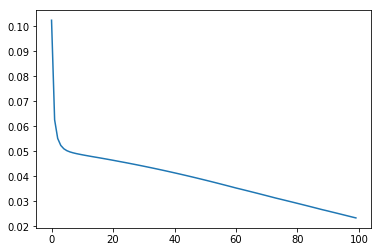

In [7]:
tf.reset_default_graph()
layer_weights = build_cancel_out_Net(X1, Y1)

In [8]:
# print(np.argsort(layer_weights, axis=1))
print(np.argsort(layer_weights, axis=1)[0])

[ 7 27 26 12 23  2  0  1 11  9 20 15 13 28 22 17  3 16 14 24 21 19 29 10  8
  5  6 25  4 18]


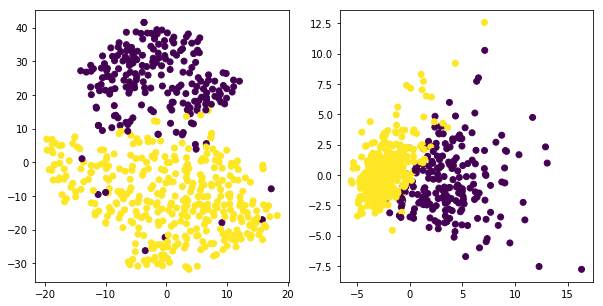

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
X_tsne = TSNE(learning_rate=100).fit_transform(X1)
X_pca = PCA().fit_transform(X1)
 
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y1)
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y1)
plt.show()